# Importing Necessary Libraries


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
# Libraries to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
from sklearn.model_selection import train_test_split
# Libraries for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [10]:
pd.set_option('display.max_columns', None)

# Loading The Data


In [11]:
ls

01_Model_building.ipynb  images/            pipeline.pkl      solution/
data/                    __init__.py        readme.md
data_cleaning.ipynb      label_encoder.pkl  requirements.txt
EDA.ipynb                main.py            scraping.ipynb


In [13]:
# using data set without dropping dummies and duplicates
original_df = pd.read_csv("data/train_df_for_model_v1.csv")

In [16]:
df = original_df.copy()

# Preprocessing


In [17]:
# checking first 5 rows
df.head()

,datasheet_link,target_col,content,datasheet_link_processed,link_num_char,num_link_words,num_link_sent,content_num_char,num_content_words,num_content_sent,transformed_text,transformed_link
0,https://lfillumination.com/files/specsheets/EF...,lighting,| ILLUMINATION Magnate Moun ...,lfillumination.com files specsheets EF408B-Lig...,65,3,1,350,53,2,illumin magnat moun freten tock 2804 ey 75109 ...,file specsheet
1,https://lfillumination.com/files/specsheets/EF...,lighting,| EF400 System # EF407B . DIE CAST CYLINDRICAL...,lfillumination.com files specsheets EF407B-Lig...,65,3,1,475,82,3,ef400 system ef407b die cast cylindr light uni...,file specsheet
2,https://www.waclighting.com/storage/waclightin...,lighting,ADJUSTABLE BEAM WALL WASH 12V 5221 vba alight ...,storage waclighting-images specsheet_pdf 5221_...,83,3,1,935,153,3,adjust beam wall wash 12v 5221 vba alight ns s...,storag
3,https://www.acuitybrands.com/api/products/geta...,lighting,HEALTHCARE mons Wa LIGHTING. | HDMC Surface Mo...,api products getasset healthcare-lighting 1626...,184,15,1,5106,973,14,healthcar mon wa light hdmc surfac mount filte...,api product getasset 1626980 2f23 3a13 3a41
4,https://lfillumination.com/files/specsheets/KA...,lighting,iF KATRPB CYLINDER PENDANT MOUNT ILLUMINATION ...,lfillumination.com files specsheets KATRPB-Pen...,62,3,1,379,77,2,katrpb cylind pendant mount illumin integr dri...,file specsheet


In [18]:
# total size of the data set
print("Number of Rows in data: ", df.shape[0])
print("Number of columns in data: ", df.shape[1])

Number of Rows in data:  952
Number of columns in data:  12


In [19]:
df.columns

Index(['datasheet_link', 'target_col', 'content', 'datasheet_link_processed',
       'link_num_char', 'num_link_words', 'num_link_sent', 'content_num_char',
       'num_content_words', 'num_content_sent', 'transformed_text',
       'transformed_link'],
      dtype='object')

In [20]:
df = df[['target_col', 'num_link_words', 'num_content_words',
         'transformed_text', 'transformed_link']]

In [21]:
df.head()

,target_col,num_link_words,num_content_words,transformed_text,transformed_link
0,lighting,3,53,illumin magnat moun freten tock 2804 ey 75109 ...,file specsheet
1,lighting,3,82,ef400 system ef407b die cast cylindr light uni...,file specsheet
2,lighting,3,153,adjust beam wall wash 12v 5221 vba alight ns s...,storag
3,lighting,15,973,healthcar mon wa light hdmc surfac mount filte...,api product getasset 1626980 2f23 3a13 3a41
4,lighting,3,77,katrpb cylind pendant mount illumin integr dri...,file specsheet


In [22]:
df.shape

(952, 5)

In [23]:
df.isnull().sum()[df.isnull().sum() > 0]

transformed_text      1
transformed_link    118
dtype: int64

In [24]:
df.dropna(subset=['transformed_text'], inplace=True)

In [25]:
df['transformed_link'].mode()

0    storag
Name: transformed_link, dtype: object

In [26]:
mode_value = df['transformed_link'].mode()[0]
mode_value

'storag'

In [27]:
distribution_before = df['transformed_link'].value_counts(dropna=False)
print("Distribution Before Imputation:")
print(distribution_before)

Distribution Before Imputation:
transformed_link
NaN                                    118
storag                                  81
product                                 78
commerc documentdeliveri ddecontrol     61
specsheet2                              50
                                      ... 
product 1676588058                       1
product 1676619669                       1
product 1676619652                       1
product 1676595983                       1
product 1676608268                       1
Name: count, Length: 287, dtype: int64


In [28]:
mode_value = df['transformed_link'].mode()[0]

# Fill missing values with the mode
distribution_after = df['transformed_link'].fillna(
    mode_value).value_counts(dropna=False)

# Calculate the distribution after imputation
print("\nDistribution After Imputation:")
print(distribution_after)


Distribution After Imputation:
transformed_link
storag                                 199
product                                 78
commerc documentdeliveri ddecontrol     61
specsheet2                              50
media                                   47
                                      ... 
product 1676596004                       1
product 1676588058                       1
product 1676619669                       1
product 1676619652                       1
product 1676608268                       1
Name: count, Length: 286, dtype: int64


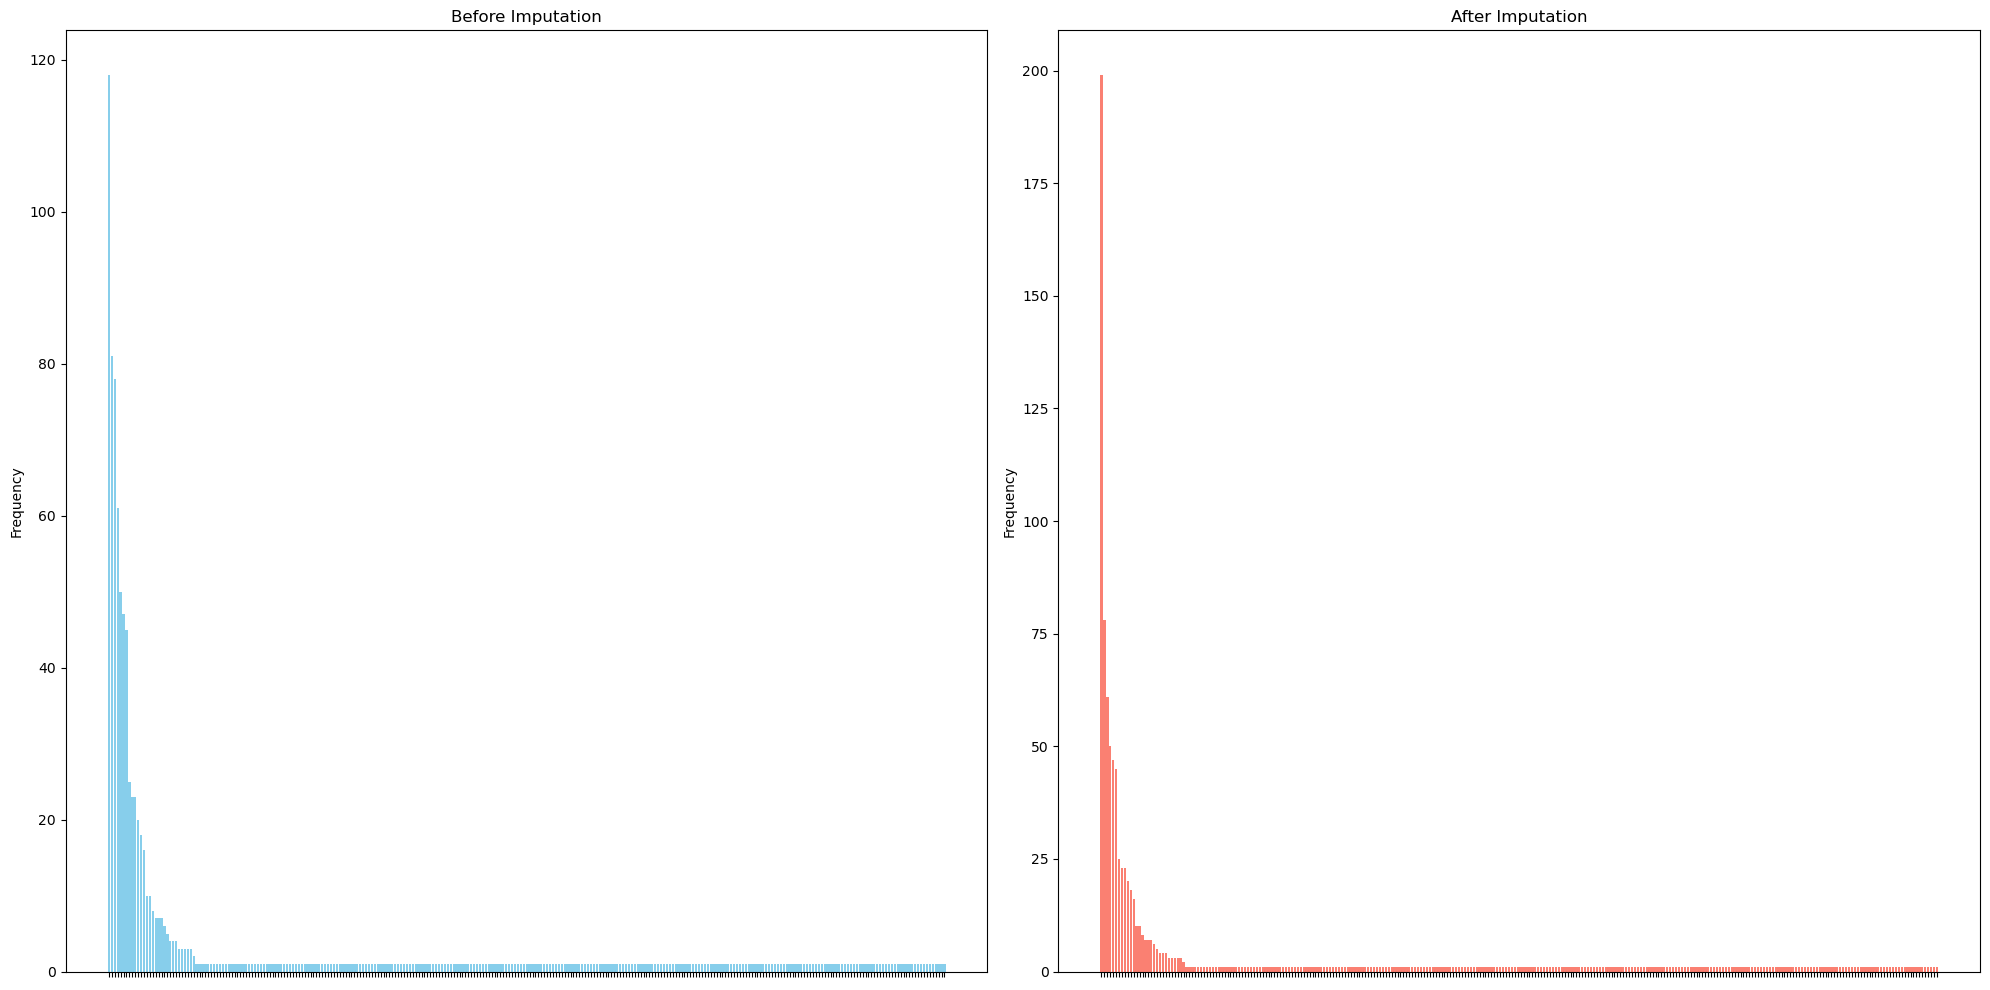

In [29]:

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Before Imputation
axes[0].bar(distribution_before.index.astype(str),
            distribution_before.values, color='skyblue')
axes[0].set_title('Before Imputation')
axes[0].set_xlabel('')  # Remove x-axis label
axes[0].set_ylabel('Frequency')

# After Imputation
axes[1].bar(distribution_after.index.astype(str),
            distribution_after.values, color='salmon')
axes[1].set_title('After Imputation')
axes[1].set_xlabel('')  # Remove x-axis label
axes[1].set_ylabel('Frequency')

# Hide x-axis labels
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

plt.tight_layout()
plt.show()

In [30]:
df['transformed_link'] = df['transformed_link'].fillna(mode_value)

In [31]:
df.isnull().sum()

target_col           0
num_link_words       0
num_content_words    0
transformed_text     0
transformed_link     0
dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 951 entries, 0 to 951
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   target_col         951 non-null    object
 1   num_link_words     951 non-null    int64 
 2   num_content_words  951 non-null    int64 
 3   transformed_text   951 non-null    object
 4   transformed_link   951 non-null    object
dtypes: int64(2), object(3)
memory usage: 44.6+ KB


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

In [34]:
tfidf_vectorizer1 = TfidfVectorizer()
tfidf_vectorizer2 = TfidfVectorizer()

In [35]:
df['transformed_link'] = tfidf_vectorizer1.fit_transform(
    df['transformed_link']).toarray()

In [36]:
df['transformed_text'] = tfidf_vectorizer2.fit_transform(
    df['transformed_text']).toarray()

In [37]:
df.head()

,target_col,num_link_words,num_content_words,transformed_text,transformed_link
0,lighting,3,53,0.0,0.0
1,lighting,3,82,0.0,0.0
2,lighting,3,153,0.0,0.0
3,lighting,15,973,0.0,0.0
4,lighting,3,77,0.0,0.0


In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
enc = LabelEncoder()

In [40]:
df['target_col'] = enc.fit_transform(df['target_col'])

In [41]:
df.head()

,target_col,num_link_words,num_content_words,transformed_text,transformed_link
0,2,3,53,0.0,0.0
1,2,3,82,0.0,0.0
2,2,3,153,0.0,0.0
3,2,15,973,0.0,0.0
4,2,3,77,0.0,0.0


In [42]:
# creating dependent and independent variables sets
X = df.drop(columns='target_col')
y = df["target_col"]

In [43]:
print("shape of x", X.shape)
print("Shape of y", y.shape)

shape of x (951, 4)
Shape of y (951,)


In [44]:
y

0      2
1      2
2      2
3      2
4      2
      ..
947    3
948    3
949    3
950    3
951    3
Name: target_col, Length: 951, dtype: int64

In [45]:
# Creating train set and test s
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [46]:
print("Shape of X_train", X_train.shape)
print("Shape of X_test",  X_test.shape)

Shape of X_train (760, 4)
Shape of X_test (191, 4)


In [47]:
print("Shape of y_train", y_train.shape)
print("Shape of y_test",  y_test.shape)

Shape of y_train (760,)
Shape of y_test (191,)


# Building Machine Learning Models


In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
sc = StandardScaler()

In [148]:
sc.fit(X_train)

StandardScaler()

In [153]:
X_train_scaled = sc.fit_transform(X_train)

In [152]:
X_test_scaled = sc.transform(X_test)

In [155]:
X_train_scaled

array([[-0.66495477, -0.34452652, -0.30082688, -0.0362977 ],
       [-0.66495477, -0.33464389, -0.30082688, -0.0362977 ],
       [-0.66495477,  0.01248332,  1.37508154, -0.0362977 ],
       ...,
       [-0.66495477, -0.09622556, -0.30082688, -0.0362977 ],
       [-0.66495477, -0.12463811, -0.30082688, -0.0362977 ],
       [-0.66495477, -0.32476127, -0.30082688, -0.0362977 ]])

In [156]:
X_test_scaled

array([[-0.66541829,  0.16580807, -0.3360804 , -0.07254763],
       [-0.66541829, -0.6086182 , -0.3360804 , -0.07254763],
       [-0.66541829, -0.74003599, -0.3360804 , -0.07254763],
       [ 0.46935755, -0.31762166, -0.3360804 , -0.07254763],
       [ 1.03674546, -0.30588793, -0.3360804 , -0.07254763],
       [-0.66541829, -0.22375181, -0.3360804 , -0.07254763],
       [-0.66541829,  1.48233273, -0.3360804 , -0.07254763],
       [-0.66541829, -0.39741104, -0.3360804 , -0.07254763],
       [-0.66541829,  1.23123088, -0.3360804 , -0.07254763],
       [-0.66541829, -0.28946071, -0.3360804 , 13.78404875],
       [-0.66541829, -0.80809164, -0.3360804 , -0.07254763],
       [-0.66541829, -0.37863707, -0.3360804 , -0.07254763],
       [-0.66541829, -0.08764053, -0.3360804 , -0.07254763],
       [ 0.46935755,  0.15642108, -0.3360804 , -0.07254763],
       [-0.66541829,  1.01533022, -0.3360804 , -0.07254763],
       [-0.66541829, -0.39975778, -0.3360804 , -0.07254763],
       [-0.66541829, -0.

## Logistic Regression


In [157]:
# training the model
from sklearn.linear_model import LogisticRegression
log_reg_classifier = LogisticRegression(random_state=0)
log_reg_classifier.fit(X_train_scaled, y_train)

LogisticRegression(random_state=0)

In [158]:
# Making prediction on our train and test dataset
log_reg_pred_train = log_reg_classifier.predict(X_train_scaled)
log_reg_pred_test = log_reg_classifier.predict(X_test_scaled)

In [159]:
# Storing train and test accuracy scores
log_reg_train_accuracy = accuracy_score(y_train, log_reg_pred_train)
log_reg_test_accuracy = accuracy_score(y_test, log_reg_pred_test)

# printing train and test accuracy scores
print("Training accuracy Score    : ", log_reg_train_accuracy)
print("Test accuracy Score : ", log_reg_test_accuracy)

# printing classification report for the performance of train and test set
print("\n", "Logistic Regression Classification Report for train dataset", "\n")
print(classification_report(y_train, log_reg_pred_train))
print("Logistic Regression Classification Report for test dataset", "\n")
print(classification_report(y_test, log_reg_pred_test))

Training accuracy Score    :  0.5723684210526315
Test accuracy Score :  0.5549738219895288

 Logistic Regression Classification Report for train dataset 

              precision    recall  f1-score   support

           0       0.34      0.17      0.23       182
           1       0.00      0.00      0.00        94
           2       0.58      0.92      0.71       364
           3       0.78      0.57      0.66       120

    accuracy                           0.57       760
   macro avg       0.42      0.42      0.40       760
weighted avg       0.48      0.57      0.50       760

Logistic Regression Classification Report for test dataset 

              precision    recall  f1-score   support

           0       0.32      0.16      0.21        44
           1       0.00      0.00      0.00        31
           2       0.55      0.89      0.68        81
           3       0.73      0.77      0.75        35

    accuracy                           0.55       191
   macro avg       0.40

## K-NN Classifier


In [161]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(
    n_neighbors=5, metric='minkowski', p=2)
knn_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [162]:
# Making prediction on our train and test dataset
knn_pred_train = knn_classifier.predict(X_train_scaled)
knn_pred_test = knn_classifier.predict(X_test_scaled)

In [163]:


# Storing train and test accuracy scores
train_accuracy = accuracy_score(y_train, knn_pred_train)
test_accuracy = accuracy_score(y_test, knn_pred_test)

# printing train and test accuracy scores
print("Training accuracy Score    : ", train_accuracy)
print("Test accuracy Score : ", test_accuracy)

# printing classification report for the performance of train and test set
print("\n", "KNN Classification Report for train dataset", "\n")
print(classification_report(y_train, knn_pred_train))
print("KNN Classification Report for test dataset", "\n")
print(classification_report(y_test, knn_pred_test))

Training accuracy Score    :  0.7868421052631579
Test accuracy Score :  0.612565445026178

 KNN Classification Report for train dataset 

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       182
           1       0.68      0.74      0.71        94
           2       0.83      0.86      0.85       364
           3       0.85      0.68      0.76       120

    accuracy                           0.79       760
   macro avg       0.77      0.75      0.76       760
weighted avg       0.79      0.79      0.79       760

KNN Classification Report for test dataset 

              precision    recall  f1-score   support

           0       0.63      0.43      0.51        44
           1       0.41      0.61      0.49        31
           2       0.69      0.84      0.76        81
           3       0.65      0.31      0.42        35

    accuracy                           0.61       191
   macro avg       0.60      0.55      0.55       191
we

## Support Vector Machine (SVM)


In [167]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', random_state=0)
svm_classifier.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=0)

In [168]:
# Making prediction on our train and test dataset
svm_pred_train = svm_classifier.predict(X_train_scaled)
svm_pred_test = svm_classifier.predict(X_test_scaled)

In [169]:

# Storing train and test accuracy scores
train_accuracy = accuracy_score(y_train, svm_pred_train)
test_accuracy = accuracy_score(y_test, svm_pred_test)

# printing train and test accuracy scores
print("Training accuracy Score    : ", train_accuracy)
print("Test accuracy Score : ", test_accuracy)

# printing classification report for the performance of train and test set
print("\n", "SVM Classification Report for train dataset", "\n")
print(classification_report(y_train, svm_pred_train))
print("SVM Classification Report for test dataset", "\n")
print(classification_report(y_test, svm_pred_test))

Training accuracy Score    :  0.5789473684210527
Test accuracy Score :  0.5549738219895288

 SVM Classification Report for train dataset 

              precision    recall  f1-score   support

           0       0.45      0.16      0.24       182
           1       0.00      0.00      0.00        94
           2       0.59      0.91      0.72       364
           3       0.60      0.64      0.62       120

    accuracy                           0.58       760
   macro avg       0.41      0.43      0.39       760
weighted avg       0.49      0.58      0.50       760

SVM Classification Report for test dataset 

              precision    recall  f1-score   support

           0       0.33      0.14      0.19        44
           1       0.00      0.00      0.00        31
           2       0.55      0.89      0.68        81
           3       0.65      0.80      0.72        35

    accuracy                           0.55       191
   macro avg       0.38      0.46      0.40       191
w

## Kernal Support Vector Machine (K-SVM)


In [170]:
from sklearn.svm import SVC
k_svm_classifier = SVC(kernel='rbf', random_state=0)
k_svm_classifier.fit(X_train_scaled, y_train)

SVC(random_state=0)

In [171]:
# Making prediction on our train and test dataset
k_svm_pred_train = k_svm_classifier.predict(X_train_scaled)
k_svm_pred_test = k_svm_classifier.predict(X_test_scaled)

In [172]:

# Storing train and test accuracy scores
k_svm_train_accuracy = accuracy_score(y_train, k_svm_pred_train)
k_svm_test_accuracy = accuracy_score(y_test, k_svm_pred_test)

# printing train and test accuracy scores
print("Training accuracy Score    : ", train_accuracy)
print("Test accuracy Score : ", test_accuracy)

# printing classification report for the performance of train and test set
print("\n", "Kernal-SVM Classification Report for train dataset", "\n")
print(classification_report(y_train, k_svm_pred_train))
print("Kernal-SVM Classification Report for test dataset", "\n")
print(classification_report(y_test, k_svm_pred_test))

Training accuracy Score    :  0.5789473684210527
Test accuracy Score :  0.5549738219895288

 Kernal-SVM Classification Report for train dataset 

              precision    recall  f1-score   support

           0       0.59      0.40      0.48       182
           1       0.59      0.11      0.18        94
           2       0.69      0.97      0.80       364
           3       0.70      0.62      0.65       120

    accuracy                           0.67       760
   macro avg       0.64      0.52      0.53       760
weighted avg       0.65      0.67      0.63       760

Kernal-SVM Classification Report for test dataset 

              precision    recall  f1-score   support

           0       0.52      0.39      0.44        44
           1       0.38      0.10      0.15        31
           2       0.65      0.95      0.77        81
           3       0.78      0.71      0.75        35

    accuracy                           0.64       191
   macro avg       0.58      0.54      0.

## NAIVE BAYES


In [174]:
from sklearn.naive_bayes import MultinomialNB
# building pipe line for naive bayes

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [175]:
# Making prediction on our train and test dataset
nb_pred_train = nb_classifier.predict(X_train)
nb_test_pred = nb_classifier.predict(X_test)

In [177]:

# Storing train and test accuracy scores
train_accuracy = accuracy_score(y_train, nb_pred_train)
test_accuracy = accuracy_score(y_test, nb_test_pred)

# printing train and test accuracy scores
print("Training accuracy Score    : ", train_accuracy)
print("Test accuracy Score : ", test_accuracy)

# printing classification report for the performance of train and test set
print("\n", "Naive Bayes Classification Report for train dataset", "\n")
print(classification_report(y_train, nb_pred_train))
print("Naive Bayes Classification Report for test dataset", "\n")
print(classification_report(y_test, nb_test_pred))

Training accuracy Score    :  0.5421052631578948
Test accuracy Score :  0.5235602094240838

 Naive Bayes Classification Report for train dataset 

              precision    recall  f1-score   support

           0       0.34      0.14      0.20       182
           1       0.00      0.00      0.00        94
           2       0.60      0.83      0.70       364
           3       0.47      0.70      0.56       120

    accuracy                           0.54       760
   macro avg       0.35      0.42      0.36       760
weighted avg       0.44      0.54      0.47       760

Naive Bayes Classification Report for test dataset 

              precision    recall  f1-score   support

           0       0.29      0.11      0.16        44
           1       0.00      0.00      0.00        31
           2       0.55      0.80      0.65        81
           3       0.54      0.86      0.66        35

    accuracy                           0.52       191
   macro avg       0.35      0.44      

## DECISION Trees


In [178]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(
    criterion='gini', random_state=0)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [179]:
# Making prediction on our train and test dataset
dt_pred_train = dt_classifier.predict(X_train)
dt_test_pred = dt_classifier.predict(X_test)

In [180]:


# Storing train and test accuracy scores
train_accuracy = accuracy_score(y_train, dt_pred_train)
test_accuracy = accuracy_score(y_test, dt_test_pred)

# printing train and test accuracy scores
print("Training accuracy Score    : ", train_accuracy)
print("Test accuracy Score : ", test_accuracy)

# printing classification report for the performance of train and test set
print("\n", "Decision Tree Classification Report for train dataset", "\n")
print(classification_report(y_train, dt_pred_train))
print("Decision Tree Classification Report for test dataset", "\n")
print(classification_report(y_test, dt_test_pred))

Training accuracy Score    :  0.9394736842105263
Test accuracy Score :  0.6335078534031413

 Decision Tree Classification Report for train dataset 

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       182
           1       0.90      0.98      0.94        94
           2       0.96      0.93      0.95       364
           3       0.98      0.93      0.95       120

    accuracy                           0.94       760
   macro avg       0.93      0.95      0.94       760
weighted avg       0.94      0.94      0.94       760

Decision Tree Classification Report for test dataset 

              precision    recall  f1-score   support

           0       0.44      0.55      0.48        44
           1       0.69      0.65      0.67        31
           2       0.72      0.65      0.68        81
           3       0.73      0.69      0.71        35

    accuracy                           0.63       191
   macro avg       0.64      0.63  

## Random Forest


In [181]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(
    n_estimators=10, criterion='gini', random_state=0)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [182]:
# Making prediction on our train and test dataset
rf_pred_train = rf_classifier.predict(X_train)
rf_pred_test = rf_classifier.predict(X_test)

In [183]:


# Storing train and test accuracy scores
train_accuracy = accuracy_score(y_train, rf_pred_train)
test_accuracy = accuracy_score(y_test, rf_pred_test)

# printing train and test accuracy scores
print("Training accuracy Score    : ", train_accuracy)
print("Test accuracy Score : ", test_accuracy)

# printing classification report for the performance of train and test set
print("\n", "Random Forest Classification Report for train dataset", "\n")
print(classification_report(y_train, rf_pred_train))
print("Random Classification Report for test dataset", "\n")
print(classification_report(y_test, rf_pred_test))

Training accuracy Score    :  0.9131578947368421
Test accuracy Score :  0.6910994764397905

 Random Forest Classification Report for train dataset 

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       182
           1       0.91      0.86      0.89        94
           2       0.93      0.93      0.93       364
           3       0.93      0.90      0.92       120

    accuracy                           0.91       760
   macro avg       0.91      0.90      0.91       760
weighted avg       0.91      0.91      0.91       760

Random Classification Report for test dataset 

              precision    recall  f1-score   support

           0       0.49      0.64      0.55        44
           1       0.79      0.71      0.75        31
           2       0.74      0.72      0.73        81
           3       0.86      0.69      0.76        35

    accuracy                           0.69       191
   macro avg       0.72      0.69      0.7

Random Forest Has Better Accuracy so we are selecting random forest as final model


# Cross Validation And Hyper Parameter Tuning


## Applying k-Fold Cross Validation


In [186]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(
    estimator=rf_classifier, X=X_train, y=y_train, cv=10, scoring='accuracy')
print("Accuracy: {:.2f} %".format(score.mean()*100))
print("Standard Deviation: {:.2f} %".format(score.std()*100))

Accuracy: 67.24 %
Standard Deviation: 4.61 %


## Applying Grid Search to find the best model and the best parameters


In [61]:
df = original_df.copy()

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

In [64]:

text_preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'transformed_text'),
        ('link', TfidfVectorizer(), 'transformed_link')
    ],
    sparse_threshold=0  # Ensure the output is a sparse matrix
)

# Define the full preprocessing and modeling pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('text', text_preprocessor, [
             'transformed_text', 'transformed_link'])
        ]
    )),
    ('classifier', RandomForestClassifier())
])

In [65]:
df = df[['target_col', 'num_link_words', 'num_content_words',
         'transformed_text', 'transformed_link']]

In [66]:
df.dropna(subset=['transformed_text'], inplace=True)

In [67]:
mode_value = df['transformed_link'].mode()[0]

In [68]:
df['transformed_link'] = df['transformed_link'].fillna(mode_value)

In [69]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df['target_col'] = enc.fit_transform(df['target_col'])

In [70]:
X = df.drop('target_col', axis=1)
y = df['target_col']

In [71]:
y

0      2
1      2
2      2
3      2
4      2
      ..
947    3
948    3
949    3
950    3
951    3
Name: target_col, Length: 951, dtype: int64

In [72]:
X

,num_link_words,num_content_words,transformed_text,transformed_link
0,3,53,illumin magnat moun freten tock 2804 ey 75109 ...,file specsheet
1,3,82,ef400 system ef407b die cast cylindr light uni...,file specsheet
2,3,153,adjust beam wall wash 12v 5221 vba alight ns s...,storag
3,15,973,healthcar mon wa light hdmc surfac mount filte...,api product getasset 1626980 2f23 3a13 3a41
4,3,77,katrpb cylind pendant mount illumin integr dri...,file specsheet
...,...,...,...,...
947,3,948,microsemi qualiti investor sale contact parame...,storag
948,3,948,microsemi qualiti investor sale contact parame...,storag
949,3,948,microsemi qualiti investor sale contact parame...,storag
950,3,948,microsemi qualiti investor sale contact parame...,storag


In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [74]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  ColumnTransformer(sparse_threshold=0,
                                                                    transformers=[('text',
                                                                                   TfidfVectorizer(),
                                                                                   'transformed_text'),
                                                                                  ('link',
                                                                                   TfidfVectorizer(),
                                                                                   'transformed_link')]),
                                                  ['transformed_text',
                                                   'transformed_link'])])),
                ('classifier', RandomForestClassifier())])

In [24]:
y_pred_rf_pipe = pipeline.predict(X_test)

In [25]:
from sklearn.model_selection import GridSearchCV
# Creating parameter dictionary for hyperparameter tuning

param_grid = {
    # Unigrams and bigrams
    'preprocessor__text__text__ngram_range': [(1, 1), (1, 2)],
    'preprocessor__text__link__ngram_range': [(1, 1), (1, 2)],
    # Maximum number of features
    'preprocessor__text__text__max_features': [None, 500, 1000],
    'preprocessor__text__link__max_features': [None, 500, 1000],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Performing cross validation and hyperparameter tuning
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=10,
                           n_jobs=-1)

# Fitting the model on the train dataset
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         ColumnTransformer(sparse_threshold=0,
                                                                                           transformers=[('text',
                                                                                                          TfidfVectorizer(),
                                                                                                          'transformed_text'),
                                                                                                         ('link',
                                                                                                          TfidfVectorizer(),
                                                                                                          'transformed_link')]),
                                                                         ['transformed_text',
                                                                          'transformed_link'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_gr...r__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200],
                         'preprocessor__text__link__max_features': [None, 500,
                                                                    1000],
                         'preprocessor__text__link__ngram_range': [(1, 1),
                                                                   (1, 2)],
                         'preprocessor__text__text__max_features': [None, 500,
                                                                    1000],
                         'preprocessor__text__text__ngram_range': [(1, 1),
                                                                   (1, 2)]},
             scoring='accuracy')

In [91]:
# grid_search = model

In [93]:
# Making prediction on our train and test dataset
rf_grid_pred_train = grid_search.predict(X_train)
rf_grid_pred_test = grid_search.predict(X_test)

In [94]:
# Storing train and test accuracy scores
rf_grid_train_accuracy = accuracy_score(y_train, rf_grid_pred_train)
rf_grid_test_accuracy = accuracy_score(y_test, rf_grid_pred_test)


# Obtaining best parameters
best_parameters = grid_search.best_params_
print("Best hyperparameter for the random forest Model are:", best_parameters)
best_accuracy = grid_search.best_score_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))


# printing train and test accuracy scores
print("Training accuracy Score   : ", grid_search.score(X_train, y_train))
print("Test accuracy Score : ", rf_grid_test_accuracy)


# printing classification report for the performance of train and test set
print("\n", "Randrom forest model Grid Model-Classification Report for train dataset", "\n")
print(classification_report(rf_grid_pred_train, y_train))
print("Naive Bayes Grid Model-Classification Report for test dataset", "\n")
print(classification_report(rf_grid_pred_test, y_test))

AttributeError: 'Pipeline' object has no attribute 'best_params_'

In [78]:
ls

01_Model_building.ipynb  images/            pipeline.pkl      solution/
data/                    __init__.py        readme.md
data_cleaning.ipynb      label_encoder.pkl  requirements.txt
EDA.ipynb                main.py            scraping.ipynb


In [79]:
# save model
# Save the model to a file
import pickle
# with open('pipeline.pkl', 'wb') as f:
#     pickle.dump(grid_search.best_estimator_, f)

# Load the model from a file
with open('pipeline.pkl', 'rb') as f:
    model = pickle.load(f)

In [80]:
single_record = X_test.head(1)

In [81]:
single_record

,num_link_words,num_content_words,transformed_text,transformed_link
199,3,494,columbia trentin featur r8o 8 control technolo...,site specsheet


In [82]:
single_row = model.named_steps['preprocessor'].transform(single_record)

In [126]:
res = model.named_steps['classifier'].predict(single_row)

In [84]:
res[0]

2

In [85]:
y_test[199]

2

In [86]:
enc.inverse_transform(res)

array(['lighting'], dtype=object)

In [56]:
# with open('label_encoder.pkl', 'wb') as file:
#     pickle.dump(enc, file)

In [87]:
with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

In [88]:
label_encoder.classes_

array(['cable', 'fuses', 'lighting', 'others'], dtype=object)

In [89]:
label_encoder.inverse_transform(res)[0]

'lighting'

In [90]:
# import pickle
# pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
# pickle.dump(nb_classifier, open('model.pkl', 'wb'))

In [178]:
# with open('model.pkl', 'rb') as file:
#     model = pickle.load(file)

# For test data


In [95]:
test_df = pd.read_csv('data/test_df_full.csv', dtype=str)

In [96]:
test_df.head()

,datasheet_link,target_col,content
0,https://lumenart.com/images/alume/awl-01_specs...,lighting,| Lumen rt AWL.O1 Optional...
1,https://lumenart.com/images/fabric/rdc/rdc_spe...,lighting,LumenArt LIGHTING SOLUTIONS. uu) RDC Series ...
2,https://lumenart.com/images/fabric/cyp/cyp_spe...,lighting,LumenAvrt CYP Series 3 SOLUTIONS CYP8x24 CY...
3,https://lumenart.com/images/designer/wlp_specs...,lighting,LumenArt WLP LIGHTING SOLUTIONS SPECIFICATIO...
4,https://lumenart.com/images/designer/wcp/wcp-s...,lighting,LumenArt WCP-S LIGHTING SOLUTIONS 43% Oak ...


In [111]:
import nltk
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
import pandas as pd


ps = PorterStemmer()


def transformation(text):
    # lower text
    text = str(text)
    text = text.lower()
    # convert into words
    text = nltk.word_tokenize(text)

    # removing special characters
    y = []
    for str_ in text:
        if str_.isalnum():
            y.append(str_)

    text = y.copy()
    y.clear()

    # removing stop words and punctuation
    for str_ in text:
        if str_ not in stopwords.words('english') and str_ not in string.punctuation:
            y.append(str_)

    text = y.copy()
    y.clear()

    # stemming
    for str_ in text:
        y.append(ps.stem(str_))

    return " ".join(y)

In [100]:
def link_preprocessor(link):
    link = " ".join([str_.strip() for str_ in link.split(
        '/') if str_.strip() and ("http" not in str_ and 'www' not in str_)])

    return link

In [104]:
test_df['datasheet_link'].apply(lambda x: len(nltk.word_tokenize(x)))

0      3
1      3
2      3
3      3
4      3
      ..
395    3
396    3
397    3
398    3
399    3
Name: datasheet_link, Length: 400, dtype: int64

In [105]:
test_df['num_link_words'] = test_df['datasheet_link'].apply(
    lambda x: len(nltk.word_tokenize(x)))

In [106]:

test_df['transformed_link'] = test_df['datasheet_link'].apply(
    link_preprocessor)
test_df

,datasheet_link,target_col,content,num_link_words,transformed_link
0,https://lumenart.com/images/alume/awl-01_specs...,lighting,| Lumen rt AWL.O1 Optional...,3,lumenart.com images alume awl-01_specs.pdf
1,https://lumenart.com/images/fabric/rdc/rdc_spe...,lighting,LumenArt LIGHTING SOLUTIONS. uu) RDC Series ...,3,lumenart.com images fabric rdc rdc_specs.pdf
2,https://lumenart.com/images/fabric/cyp/cyp_spe...,lighting,LumenAvrt CYP Series 3 SOLUTIONS CYP8x24 CY...,3,lumenart.com images fabric cyp cyp_specs.pdf
3,https://lumenart.com/images/designer/wlp_specs...,lighting,LumenArt WLP LIGHTING SOLUTIONS SPECIFICATIO...,3,lumenart.com images designer wlp_specs.pdf
4,https://lumenart.com/images/designer/wcp/wcp-s...,lighting,LumenArt WCP-S LIGHTING SOLUTIONS 43% Oak ...,3,lumenart.com images designer wcp wcp-s_specs.pdf
...,...,...,...,...,...
395,https://catalog.belden.com/techdata/EN/8219_te...,cable,BELDEN Produc i 8219 3 50 Ohm Wireless Trans...,3,catalog.belden.com techdata EN 8219_techdata.pdf
396,https://www.molex.com/pdm_docs/sd/1000680071_s...,cable,"TEMP-FLEX THE PART No, REV | PAGE: Shielded...",3,pdm_docs sd 1000680071_sd.pdf
397,https://catalog.belden.com/techdata/EN/3092A_t...,cable,"ControlBusTM, Coax RG-6, #18 Sol BCCS, FPE I...",3,catalog.belden.com techdata EN 3092A_techdata.pdf
398,https://catalog.belden.com/techdata/EN/1505A_t...,cable,"75 Ohm SDI Coax, RG-59, 20 AWG Solid BC, Foi...",3,catalog.belden.com techdata EN 1505A_techdata.pdf


In [108]:
test_df['transformed_link'] = test_df['transformed_link'].apply(transformation)

In [113]:
test_df['transformed_text'] = test_df['content'].apply(transformation)

In [114]:
test_df

,datasheet_link,target_col,content,num_link_words,transformed_link,transformed_text
0,https://lumenart.com/images/alume/awl-01_specs...,lighting,| Lumen rt AWL.O1 Optional...,3,imag alum,lumen rt option asc canopi mini tbox lumen art...
1,https://lumenart.com/images/fabric/rdc/rdc_spe...,lighting,LumenArt LIGHTING SOLUTIONS. uu) RDC Series ...,3,imag fabric rdc,lumenart light solut uu rdc seri specif constr...
2,https://lumenart.com/images/fabric/cyp/cyp_spe...,lighting,LumenAvrt CYP Series 3 SOLUTIONS CYP8x24 CY...,3,imag fabric cyp,lumenavrt cyp seri 3 solut cyp8x24 cyp8x36 cyp...
3,https://lumenart.com/images/designer/wlp_specs...,lighting,LumenArt WLP LIGHTING SOLUTIONS SPECIFICATIO...,3,imag design,lumenart wlp light solut specif construct extr...
4,https://lumenart.com/images/designer/wcp/wcp-s...,lighting,LumenArt WCP-S LIGHTING SOLUTIONS 43% Oak ...,3,imag design wcp,lumenart light solut 43 oak specif construct l...
...,...,...,...,...,...,...
395,https://catalog.belden.com/techdata/EN/8219_te...,cable,BELDEN Produc i 8219 3 50 Ohm Wireless Trans...,3,techdata en,belden produc 8219 3 50 ohm wireless transmiss...
396,https://www.molex.com/pdm_docs/sd/1000680071_s...,cable,"TEMP-FLEX THE PART No, REV | PAGE: Shielded...",3,sd,part rev page shield pair molex compani 22aw 1...
397,https://catalog.belden.com/techdata/EN/3092A_t...,cable,"ControlBusTM, Coax RG-6, #18 Sol BCCS, FPE I...",3,techdata en,controlbustm coax 18 sol bcc fpe in quad al sh...
398,https://catalog.belden.com/techdata/EN/1505A_t...,cable,"75 Ohm SDI Coax, RG-59, 20 AWG Solid BC, Foi...",3,techdata en,75 ohm sdi coax 20 awg solid bc foil 95 tc bra...


In [117]:
y

0      lighting
1      lighting
2      lighting
3      lighting
4      lighting
         ...   
395       cable
396       cable
397       cable
398       cable
399       cable
Name: target_col, Length: 400, dtype: object

In [118]:
X

,content,num_link_words,transformed_link,transformed_text
0,| Lumen rt AWL.O1 Optional...,3,imag alum,lumen rt option asc canopi mini tbox lumen art...
1,LumenArt LIGHTING SOLUTIONS. uu) RDC Series ...,3,imag fabric rdc,lumenart light solut uu rdc seri specif constr...
2,LumenAvrt CYP Series 3 SOLUTIONS CYP8x24 CY...,3,imag fabric cyp,lumenavrt cyp seri 3 solut cyp8x24 cyp8x36 cyp...
3,LumenArt WLP LIGHTING SOLUTIONS SPECIFICATIO...,3,imag design,lumenart wlp light solut specif construct extr...
4,LumenArt WCP-S LIGHTING SOLUTIONS 43% Oak ...,3,imag design wcp,lumenart light solut 43 oak specif construct l...
...,...,...,...,...
395,BELDEN Produc i 8219 3 50 Ohm Wireless Trans...,3,techdata en,belden produc 8219 3 50 ohm wireless transmiss...
396,"TEMP-FLEX THE PART No, REV | PAGE: Shielded...",3,sd,part rev page shield pair molex compani 22aw 1...
397,"ControlBusTM, Coax RG-6, #18 Sol BCCS, FPE I...",3,techdata en,controlbustm coax 18 sol bcc fpe in quad al sh...
398,"75 Ohm SDI Coax, RG-59, 20 AWG Solid BC, Foi...",3,techdata en,75 ohm sdi coax 20 awg solid bc foil 95 tc bra...


In [121]:
test_df['num_content_words'] = test_df['content'].apply(
    lambda x: len(nltk.word_tokenize(str(x))))

In [122]:
test_df.head()

,datasheet_link,target_col,content,num_link_words,transformed_link,transformed_text,num_content_words
0,https://lumenart.com/images/alume/awl-01_specs...,lighting,| Lumen rt AWL.O1 Optional...,3,imag alum,lumen rt option asc canopi mini tbox lumen art...,92
1,https://lumenart.com/images/fabric/rdc/rdc_spe...,lighting,LumenArt LIGHTING SOLUTIONS. uu) RDC Series ...,3,imag fabric rdc,lumenart light solut uu rdc seri specif constr...,180
2,https://lumenart.com/images/fabric/cyp/cyp_spe...,lighting,LumenAvrt CYP Series 3 SOLUTIONS CYP8x24 CY...,3,imag fabric cyp,lumenavrt cyp seri 3 solut cyp8x24 cyp8x36 cyp...,194
3,https://lumenart.com/images/designer/wlp_specs...,lighting,LumenArt WLP LIGHTING SOLUTIONS SPECIFICATIO...,3,imag design,lumenart wlp light solut specif construct extr...,61
4,https://lumenart.com/images/designer/wcp/wcp-s...,lighting,LumenArt WCP-S LIGHTING SOLUTIONS 43% Oak ...,3,imag design wcp,lumenart light solut 43 oak specif construct l...,88


In [123]:
y = test_df['target_col']
X = test_df.drop(columns=['datasheet_link', 'target_col', 'content'], axis=1)

In [124]:
X

,num_link_words,transformed_link,transformed_text,num_content_words
0,3,imag alum,lumen rt option asc canopi mini tbox lumen art...,92
1,3,imag fabric rdc,lumenart light solut uu rdc seri specif constr...,180
2,3,imag fabric cyp,lumenavrt cyp seri 3 solut cyp8x24 cyp8x36 cyp...,194
3,3,imag design,lumenart wlp light solut specif construct extr...,61
4,3,imag design wcp,lumenart light solut 43 oak specif construct l...,88
...,...,...,...,...
395,3,techdata en,belden produc 8219 3 50 ohm wireless transmiss...,74
396,3,sd,part rev page shield pair molex compani 22aw 1...,358
397,3,techdata en,controlbustm coax 18 sol bcc fpe in quad al sh...,24
398,3,techdata en,75 ohm sdi coax 20 awg solid bc foil 95 tc bra...,32


In [125]:
y

0      lighting
1      lighting
2      lighting
3      lighting
4      lighting
         ...   
395       cable
396       cable
397       cable
398       cable
399       cable
Name: target_col, Length: 400, dtype: object

In [ ]:
# 'num_link_words': [link_len],
#         'num_content_words': [text_len],
#         'transformed_text': [text],  # Assuming text is preprocessed
#         'transformed_link': [link]

In [127]:
X_transformed = model.named_steps['preprocessor'].transform(X)

In [128]:
res = model.named_steps['classifier'].predict(X_transformed)

In [129]:
res

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [132]:
y_actual = label_encoder.fit_transform(y)

In [133]:
accuracy_score(y_actual, res)

0.63

In [136]:
print(classification_report(y_actual, res))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       125
           1       0.80      0.98      0.88        50
           2       0.43      1.00      0.60       100
           3       0.00      0.00      0.00       125

    accuracy                           0.63       400
   macro avg       0.56      0.70      0.60       400
weighted avg       0.52      0.63      0.54       400

